In [172]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

from esda.getisord import G_Local
from esda import Moran
from esda.moran import Moran_Local

import libpysal


In [173]:
df = pd.read_csv("HOUSING2.csv")

In [174]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [176]:
df["median_house_value"] = df["median_house_value"].astype(float)

In [177]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [178]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [179]:
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())

In [180]:

# Create geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Convert DataFrame to GeoDataFrame with WGS84 coordinate system
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)


In [181]:

# Display the GeoDataFrame info
gdf.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600.0,NEAR BAY,POINT (-122.23 37.88)
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,POINT (-122.22 37.86)
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,POINT (-122.24 37.85)
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,POINT (-122.25 37.85)
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,POINT (-122.25 37.85)


In [182]:


# Create an array of coordinates (using the geometry points)
coords = list(zip(gdf.geometry.x, gdf.geometry.y))


In [183]:

# Generate KNN weights matrix (using 8 nearest neighbors)
knn = libpysal.weights.KNN.from_array(coords, k=8)
knn.transform = 'R'  # row-standardization


c:\Users\Abubakar\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 67 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [184]:

# Extract the housing price values
y = gdf['median_house_value'].values


In [185]:
# Calculate Global Moran's I
mi = Moran(y, knn)
print("Global Moran's I:", mi.I)
print("P-value:", mi.p_sim)


Global Moran's I: 0.7960193078936942
P-value: 0.001


**Interpretation:**  
A Moran’s I value of approximately 0.80 (with a p-value < 0.05) indicates strong positive spatial autocorrelation. In other words, high house prices tend to cluster near other high-priced areas, and low house prices tend to cluster near other low-priced areas, more than would be expected by random chance.

In [186]:

# Calculate Local Moran's I
m_local = Moran_Local(y, knn)

# Add local Moran's I values and p-values to the GeoDataFrame
gdf['local_moran'] = m_local.Is
gdf['p_value'] = m_local.p_sim


In [187]:

gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,local_moran,p_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600.0,NEAR BAY,POINT (-122.23 37.88),3.730956,0.001
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,POINT (-122.22 37.86),2.154260,0.001
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,POINT (-122.24 37.85),1.970629,0.001
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,POINT (-122.25 37.85),1.301610,0.003
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,POINT (-122.25 37.85),1.309180,0.003


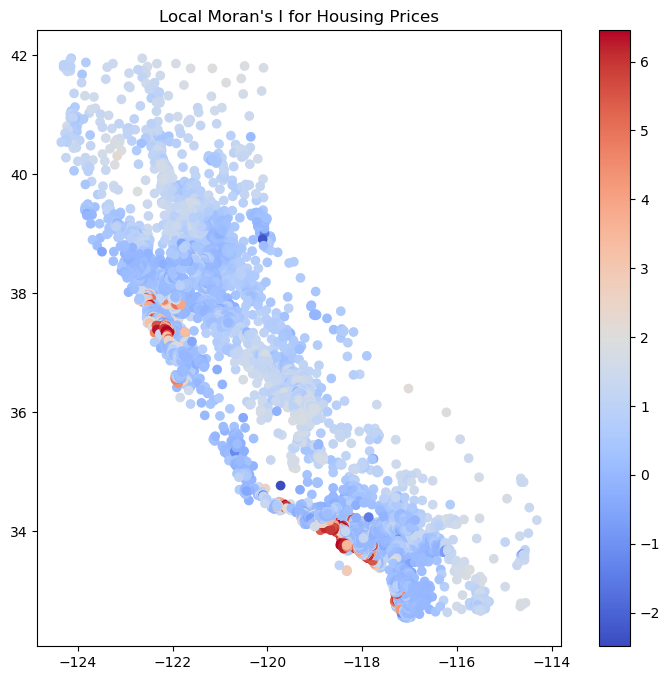

In [188]:

# Plot the local Moran's I values
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I for Housing Prices")
plt.show()


***Interpretation***

**Clusters:**

**Hotspots:** Areas with higher local Moran's I values signify regions where housing prices are significantly higher relative to surrounding areas.


**Cold Spots:** Areas with negative or low values suggest regions with lower housing prices, indicating potential undervaluation or other underlying issues.

In [189]:

# Compute Getis-Ord Gi*
g_star = G_Local(y, knn)

# Add the Gi* statistic and its p-value to the GeoDataFrame
gdf['g_stat'] = g_star.Zs
gdf['g_pvalue'] = g_star.p_sim


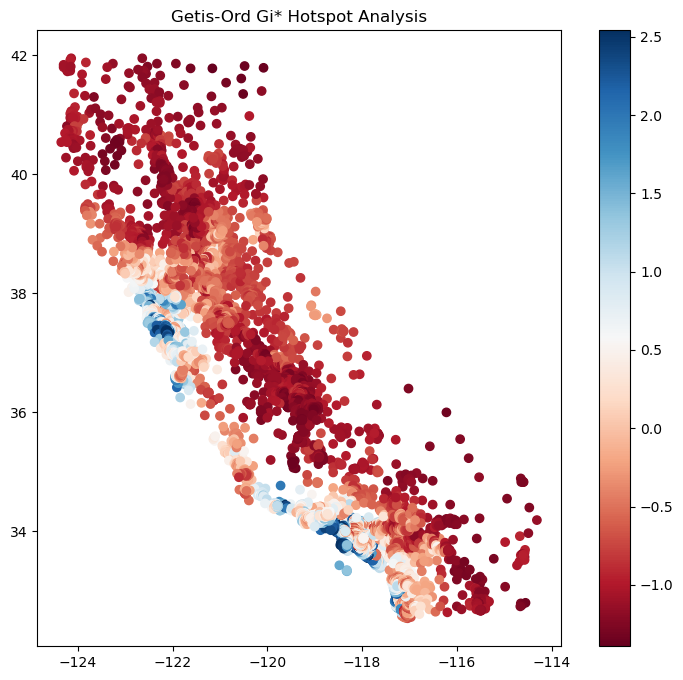

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='g_stat', cmap='RdBu', legend=True, ax=ax)
plt.title("Getis-Ord Gi* Hotspot Analysis")
plt.show()


## Interpretation of the Getis-Ord Gi\* Hotspot Analysis

The map displays the **z-scores** from the Getis-Ord Gi\* statistic for housing prices across California. Here’s what the colors indicate:

- **Red (High z-scores):** Hotspots where house values are significantly higher than their surrounding areas.  
- **Blue (Low z-scores):** Coldspots where house values are significantly lower compared to nearby locations.  
- **Neutral or Light Shades:** Areas where house values do not deviate significantly from their neighbors.

### Key Observations
1. **Northern and Central Regions:** Predominantly red, suggesting strong clusters of high house values. These areas might reflect desirable neighborhoods or regions with higher income levels and strong housing demand.
2. **Southern Areas:** Noticeable patches of blue, indicating pockets of lower house values relative to their surroundings. These could represent less affluent regions, areas with older housing stock, or locations farther from economic centers.
3. **Overall Pattern:** The distribution of hotspots and coldspots underscores that housing prices are not uniform across California. Local factors (e.g., job markets, amenities, proximity to coastlines) likely drive these high-value clusters, while other regions remain more affordable.



In [191]:
# Block of code for running GWR on full data set

# import numpy as np
# from mgwr.gwr import GWR, MGWR
# from mgwr.sel_bw import Sel_BW

# # Prepare data
# X = gdf[['housing_median_age', 'total_rooms', 'population', 'median_income']].values
# y = gdf['median_house_value'].values.reshape((-1, 1))
# coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# # Select bandwidth
# bw = Sel_BW(coords, y, X).search()
# print("Optimal bandwidth:", bw)

# # Fit GWR model
# gwr_model = GWR(coords, y, X, bw=bw).fit()
# print(gwr_model.summary)

In [192]:


#SAMPLE FROM GDF FOR BANDWIDTH SELECTION
# Here, we take a sample of 2000 rows to find an optimal bandwidth quickly.
sample_gdf = gdf.sample(n=2000, random_state=42)

y_sample = sample_gdf['median_house_value'].values.reshape((-1, 1)) # Define dependent variable 
X_sample = sample_gdf[['median_income', 'total_rooms', 'population']].values # Define independent variable
coords_sample = np.array(list(zip(sample_gdf.geometry.x, sample_gdf.geometry.y))) # Create coordinates array for GWR (using x and y from geometry)


In [193]:

# BANDWIDTH SELECTION USING SAMPLE
bw_selector = Sel_BW(coords_sample, y_sample, X_sample)
bw_sample = bw_selector.search()
print("Optimal bandwidth from sample:", bw_sample)


Optimal bandwidth from sample: 50.0


In [194]:

# FIT GWR ON THE SAMPLE
gwr_model_sample = GWR(coords_sample, y_sample, X_sample, bw=bw_sample).fit()
print(gwr_model_sample.summary())


Model type                                                         Gaussian
Number of observations:                                                2000
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       14508789608090.584
Log-likelihood:                                                  -25542.750
AIC:                                                              51093.501
AICc:                                                             51095.531
BIC:                                                           14508789592919.184
R2:                                                                   0.456
Adj. R2:                                                              0.455

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -----

In [195]:

# PREPARE FULL DATA FOR GWR
# If you want to use the sample-based bandwidth on the full dataset, do:
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
y = gdf['median_house_value'].values.reshape((-1, 1))
X = gdf[['median_income', 'total_rooms', 'population']].values


In [196]:

# FIT GWR ON THE FULL DATA USING SAMPLE BANDWIDTH
bw_final = 50  # or use bw_sample if you'd rather rely on the sample's result
gwr_model = GWR(coords, y, X, bw=bw_final).fit()
print(gwr_model.summary())


Model type                                                         Gaussian
Number of observations:                                               20640
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       143923110762867.625
Log-likelihood:                                                 -263192.933
AIC:                                                             526393.866
AICc:                                                            526395.869
BIC:                                                           143923110557849.250
R2:                                                                   0.476
Adj. R2:                                                              0.476

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---

In [197]:

# EXTRACT LOCAL COEFFICIENTS & ADD TO GDF
local_params = gwr_model.params  # shape: (n, number_of_coefficients)

# Assuming the order [Intercept, X1, X2, X3] = [b0, b1, b2, b3]
gdf['b0'] = local_params[:, 0]  # Intercept
gdf['b1'] = local_params[:, 1]  # Coefficient for median_income
gdf['b2'] = local_params[:, 2]  # Coefficient for total_rooms
gdf['b3'] = local_params[:, 3]  # Coefficient for population


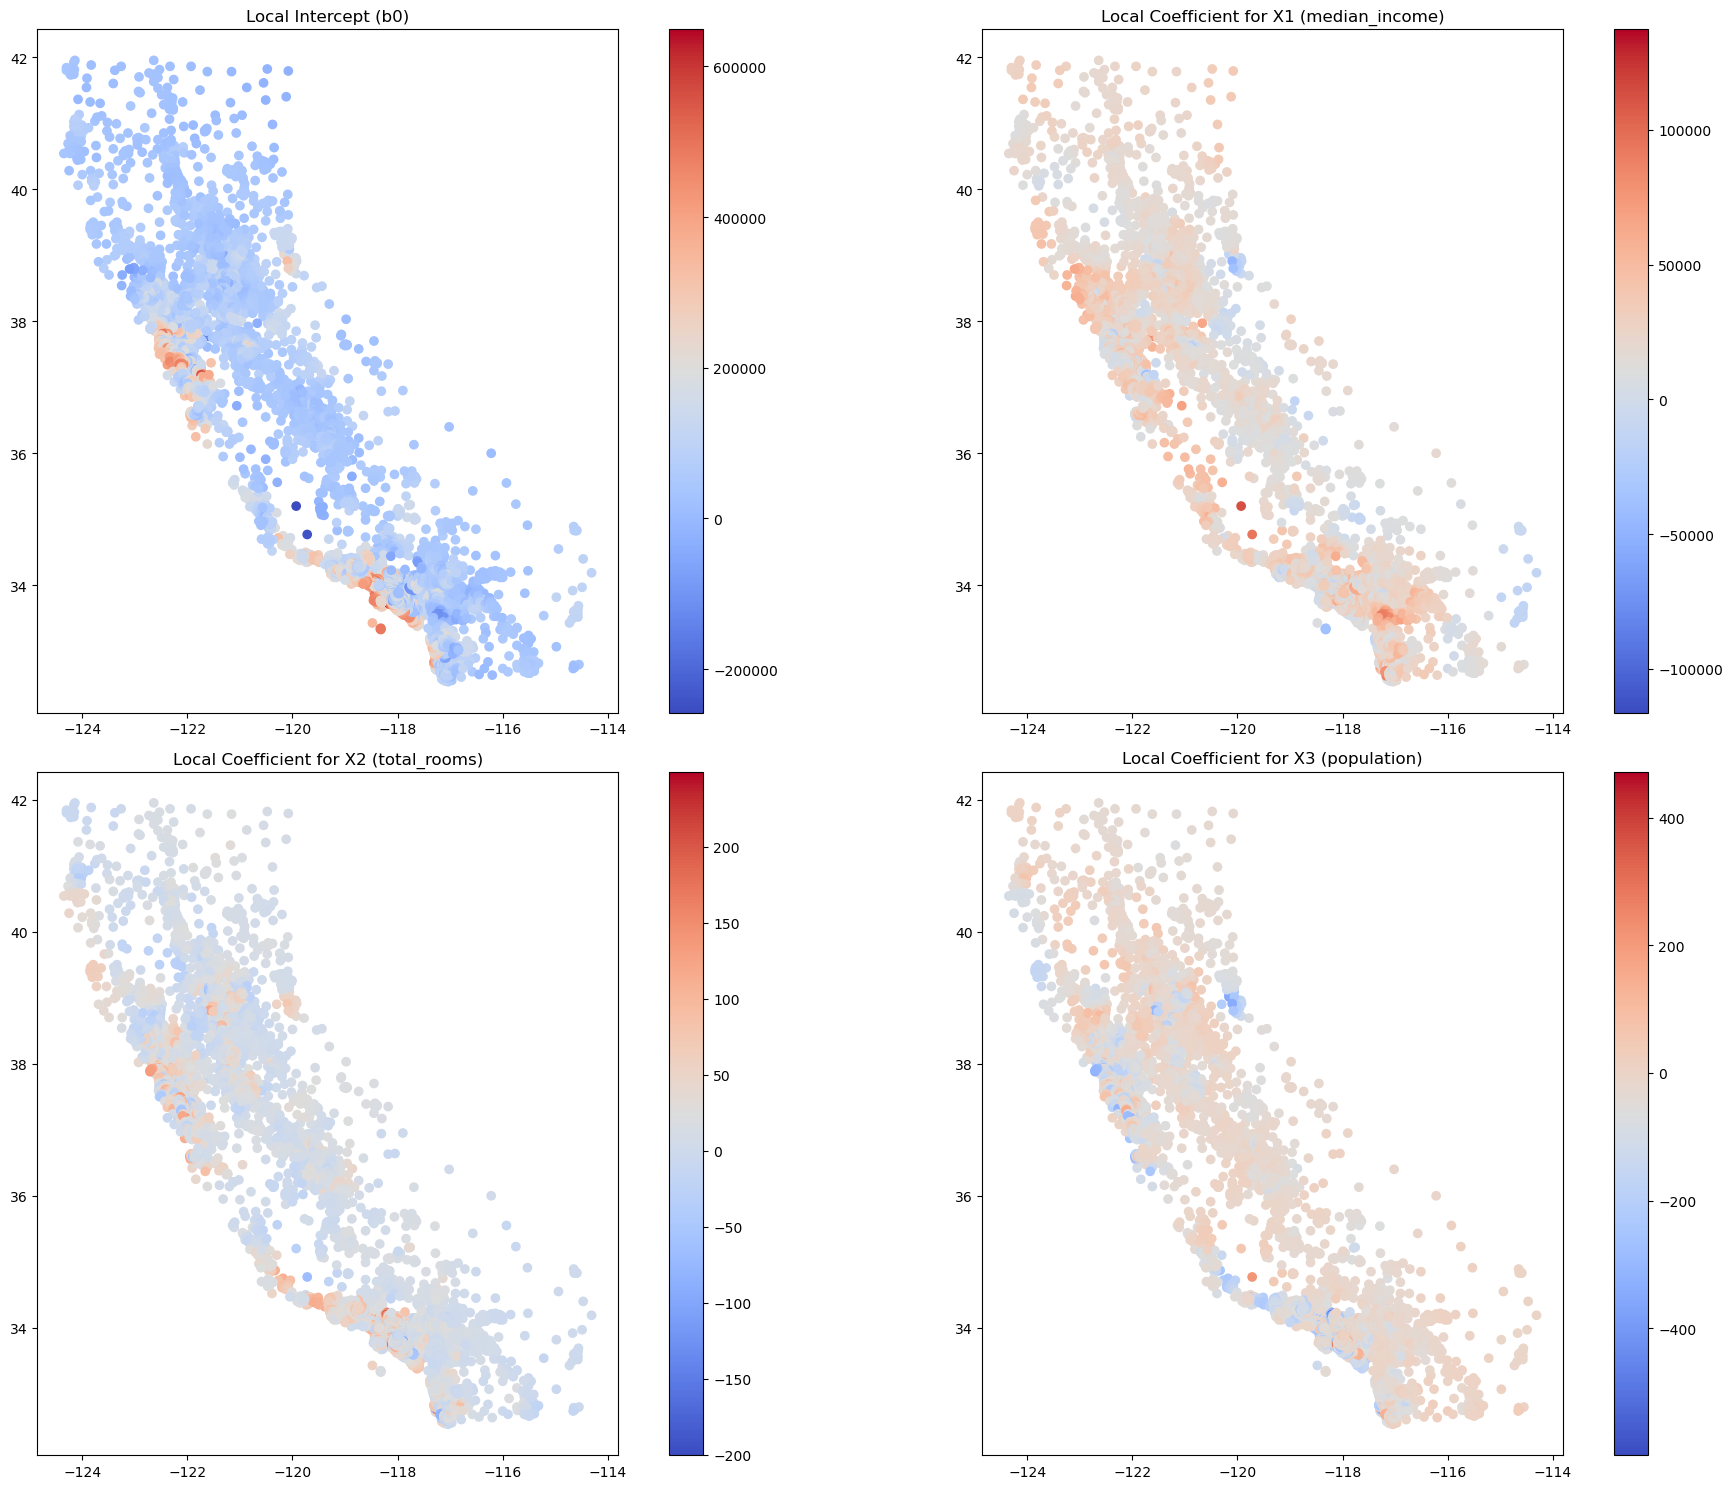

In [198]:

# PLOT LOCAL COEFFICIENTS
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Plot the Intercept (b0)
gdf.plot(column='b0', cmap='coolwarm', legend=True, ax=axs[0,0])
axs[0,0].set_title('Local Intercept (b0)')

# Plot coefficient for X1
gdf.plot(column='b1', cmap='coolwarm', legend=True, ax=axs[0,1])
axs[0,1].set_title('Local Coefficient for X1 (median_income)')

# Plot coefficient for X2
gdf.plot(column='b2', cmap='coolwarm', legend=True, ax=axs[1,0])
axs[1,0].set_title('Local Coefficient for X2 (total_rooms)')

# Plot coefficient for X3
gdf.plot(column='b3', cmap='coolwarm', legend=True, ax=axs[1,1])
axs[1,1].set_title('Local Coefficient for X3 (population)')

plt.tight_layout()
plt.show()


## Interpretation of Local GWR Coefficients

Below are four maps showing the spatial variation of local coefficients from the Geographically Weighted Regression (GWR) model:

1. **Local Intercept (b0)**
   - **Meaning**: The baseline house price (in dollars) when all other variables are held at zero.
   - **Observation**: The intercept is **higher (red)** in certain coastal and southern areas, indicating that, even after accounting for income, rooms, and population, baseline house values are higher there. In contrast, **lower (blue)** intercepts suggest regions where house prices are relatively lower once other factors are controlled for.

2. **Local Coefficient for X1 (Median Income)**
   - **Meaning**: How changes in *median income* affect house prices locally.
   - **Observation**: **Positive (red)** areas indicate a strong positive relationship between median income and house prices; as income increases, house prices rise significantly in those locations. **Negative (blue)** areas show places where higher income has less (or even inverse) impact on house prices, which could be due to local market conditions or other unmeasured factors.

3. **Local Coefficient for X2 (Total Rooms)**
   - **Meaning**: The effect of *total rooms* on house prices.
   - **Observation**: **Positive (red)** regions suggest that adding more rooms strongly increases house prices, possibly reflecting higher demand for larger homes. **Negative (blue)** areas might indicate that additional rooms do not add as much value, or there is an oversupply of large houses in those markets.

4. **Local Coefficient for X3 (Population)**
   - **Meaning**: How *population* influences house prices across different areas.
   - **Observation**: **Positive (red)** coefficients imply that higher population is associated with higher house prices, which could align with urban centers where demand is high. **Negative (blue)** coefficients indicate places where denser populations may correlate with lower house values, possibly due to congestion, housing type, or other local factors.

### Key Takeaways
- **Spatial Nonstationarity**: The significant differences in coefficient values (red vs. blue) confirm that relationships between housing prices and these factors vary substantially by location.
- **Local Insights**: Identifying where median income has the strongest effect, or where additional rooms matter most, helps stakeholders (e.g., policymakers, real estate investors) tailor decisions to local conditions.
- **Higher R² for GWR**: Compared to a global model, the GWR approach captures these localized effects, resulting in a more accurate understanding of how socioeconomic variables shape housing prices across the region.


In [204]:

'''
# Create a folder named 'visualizations' 
if not os.path.exists("visualizations"):
    os.makedirs("visualizations")

# 1. Save the Local Moran's I Map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Local Moran's I for Housing Prices")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "local_moran.png"), dpi=300)
plt.close()

# 2. Save the Getis-Ord Gi* Hotspot Analysis Map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='g_stat', cmap='RdBu', legend=True, ax=ax)
ax.set_title("Getis-Ord Gi* Hotspot Analysis")
plt.tight_layout()
plt.savefig(os.path.join("visualizations", "getis_ord_gi.png"), dpi=300)
plt.close()

# 3. Save the Local GWR Coefficients Map (4 subplots)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

gdf.plot(column='b0', cmap='coolwarm', legend=True, ax=axs[0,0])
axs[0,0].set_title("Local Intercept (b0)")

gdf.plot(column='b1', cmap='coolwarm', legend=True, ax=axs[0,1])
axs[0,1].set_title("Local Coefficient for X1 (median_income)")

gdf.plot(column='b2', cmap='coolwarm', legend=True, ax=axs[1,0])
axs[1,0].set_title("Local Coefficient for X2 (total_rooms)")

gdf.plot(column='b3', cmap='coolwarm', legend=True, ax=axs[1,1])
axs[1,1].set_title("Local Coefficient for X3 (population)")

plt.tight_layout()
plt.savefig(os.path.join("visualizations", "local_gwr_coefficients.png"), dpi=300)
plt.close()
''' 

'\n# Create a folder named \'visualizations\' \nif not os.path.exists("visualizations"):\n    os.makedirs("visualizations")\n\n# 1. Save the Local Moran\'s I Map\nfig, ax = plt.subplots(1, 1, figsize=(10, 8))\ngdf.plot(column=\'local_moran\', cmap=\'coolwarm\', legend=True, ax=ax)\nax.set_title("Local Moran\'s I for Housing Prices")\nplt.tight_layout()\nplt.savefig(os.path.join("visualizations", "local_moran.png"), dpi=300)\nplt.close()\n\n# 2. Save the Getis-Ord Gi* Hotspot Analysis Map\nfig, ax = plt.subplots(1, 1, figsize=(10, 8))\ngdf.plot(column=\'g_stat\', cmap=\'RdBu\', legend=True, ax=ax)\nax.set_title("Getis-Ord Gi* Hotspot Analysis")\nplt.tight_layout()\nplt.savefig(os.path.join("visualizations", "getis_ord_gi.png"), dpi=300)\nplt.close()\n\n# 3. Save the Local GWR Coefficients Map (4 subplots)\nfig, axs = plt.subplots(2, 2, figsize=(20, 15))\n\ngdf.plot(column=\'b0\', cmap=\'coolwarm\', legend=True, ax=axs[0,0])\naxs[0,0].set_title("Local Intercept (b0)")\n\ngdf.plot(column=

In [203]:
# Save new GeoDataFrame
gdf.to_csv('Geo_DataFrame.csv', index=False)